In [1]:
#import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import sqlite3
from sqlite3 import Error
#force output to display the full description
pd.set_option('display.max_colwidth', -1)


In [2]:
conn = sqlite3.connect('db\wine_data.sqlite')
c = conn.cursor()

In [3]:
df = pd.read_sql("Select country, description, rating, price, title, variety from wine_data where variety = 'Chardonnay'", conn)
df.head()

,country,description,rating,price,title,variety
0,Portugal,"A wood-aged Chardonnay from mountain vineyards above the Douro. The wine has spice, yellow fruits and a strong toast character. Acidity is there to add some freshness to the concentrated, rounded taste.",91,25.0,Real Companhia Velha 2009 Quinta de Cidrô Reserva Chardonnay (Duriense),Chardonnay
1,Portugal,"This oak-fermented wine may have little connection to the Douro, but it is a full, ripe and tropical-fruit flavored. The toast is only perceptible in the smooth creaminess of the texture while acidity and a crisp lemon edge give the wine an attractive final lift. Drink from late 2016.",88,25.0,Real Companhia Velha 2014 Quinta de Cidrô Chardonnay (Duriense),Chardonnay
2,Portugal,"Ripe, fruity Chardonnay, with toast flavors balancing with smooth apricot and pear juice. The wine is soft, rich and generous, finishing with a light acidity.",88,20.0,Bacalhôa Wines of Portugal 2008 Cova da Ursa Chardonnay (Península de Setúbal),Chardonnay
3,Portugal,"A wine made in memory of Catherine (Caterina) of Bragança, a Portuguese princess who married Charles II of England in the 17th century. It is a superripe wine, full of tropical fruit flavors and only the lightest of acidity. Wood aging gives the wine a plush character and suggests it could age for another year. Drink from 2016.",88,10.0,Bacalhôa Wines of Portugal 2013 Catarina Chardonnay (Península de Setúbal),Chardonnay
4,Portugal,"The chalk soil of the Cova da Ursa vineyard, high up on the Azeitão mountains, yields this rich, tropical-fruited Chardonnay. It is ripe with apricot and mango flavors that are smoothed out by the wood aging. Toast and fresh acidity are still balancing out, so this impressive wine needs to age. Drink from 2016.",92,19.0,Bacalhôa Wines of Portugal 2013 Cova da Ursa Chardonnay (Península de Setúbal),Chardonnay


In [4]:
#add a column for the word count
df['word_count'] = df['description'].apply(lambda x: len(str(x).split(" ")))

Word Count Median: 38.0
count    10234.000000
mean     38.372777   
std      10.945120   
min      3.000000    
25%      31.000000   
50%      38.000000   
75%      45.000000   
max      92.000000   
Name: word_count, dtype: float64


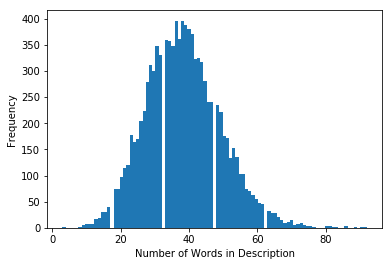

In [5]:
# print(df['rating'].unique())
# print("Number of Unique Ratings: " + str(len(df['rating'].unique())))
# print("Rating Median: " + str(df['rating'].median()))
# print(df['rating'].describe())

# print("Number of Unique prices: " + str(len(df['price'].unique())))
# print("Price Median: " + str(df['price'].median()))
# print(df['price'].describe())

print("Word Count Median: " + str(df['word_count'].median()))
print(df['word_count'].describe())

x = df['word_count']
n_bins = 95

plt.hist(x, bins=n_bins)
plt.xlabel('Number of Words in Description')
plt.ylabel('Frequency')
plt.show()

In [6]:
wc15 = df.loc[df['word_count'] < 15]
print(wc15.rating.median())
print(wc15.rating.describe())


82.0
count    64.000000
mean     82.609375
std      1.796091 
min      80.000000
25%      82.000000
50%      82.000000
75%      83.250000
max      89.000000
Name: rating, dtype: float64


Text(0.5, 1.0, 'Rating Counts')

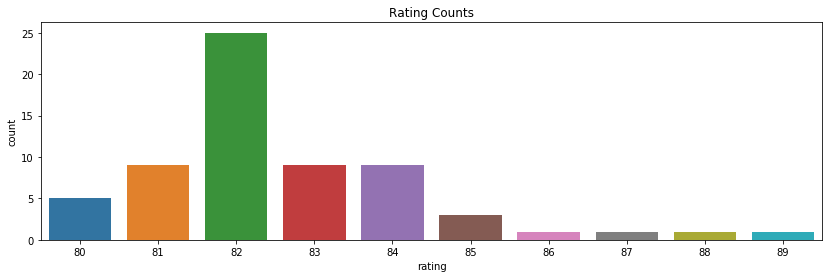

In [7]:
plt.figure(figsize=(14,4))
sns.countplot(x ='rating', data = wc15).set_title("Rating Counts")

In [8]:
wc70 = df.loc[df['word_count'] > 70]
print(wc70.rating.median())
print(wc70.rating.describe())

93.0
count    52.000000
mean     92.519231
std      2.630816 
min      85.000000
25%      91.000000
50%      93.000000
75%      94.000000
max      98.000000
Name: rating, dtype: float64


Number of Unique Ratings: 21
Rating Median: 88.0
count    10234.000000
mean     88.283662   
std      3.284805    
min      80.000000   
25%      86.000000   
50%      88.000000   
75%      91.000000   
max      100.000000  
Name: rating, dtype: float64


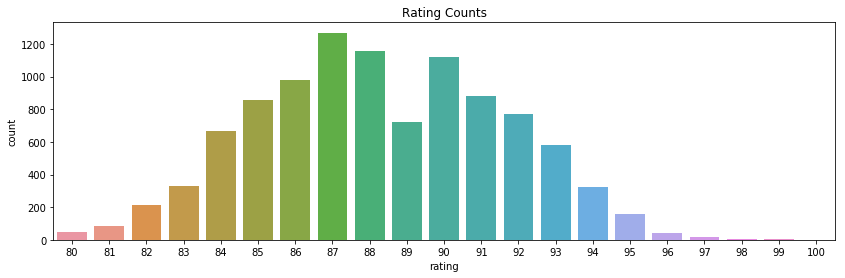

In [9]:
print("Number of Unique Ratings: " + str(len(df['rating'].unique())))
print("Rating Median: " + str(df['rating'].median()))
print(df['rating'].describe())
plt.figure(figsize=(14,4))
sns.countplot(x='rating', data=df).set_title("Rating Counts")
plt.show()

df['above_avg'] = [1 if rating > 88 else 0 for rating in df['rating']] 

In [10]:
df['above_avg'] = [1 if rating > 88 else 0 for rating in df['rating']] 
#create a list of stop words
stop_words = set(stopwords.words("english"))
#show how many words are in the list of stop words
print(len(stop_words))


#179

add_stopwords = ["wine", "drink", "chardonnay"]
stop_words = stop_words.union(add_stopwords)

179


In [11]:
import re
clean_desc = []
for w in range(len(df.description)):
    desc = df['description'][w].lower()
    
    #remove punctuations
    desc = re.sub('[^a-zA-Z]', ' ', desc)
    
    #remove tags
    desc=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",desc)
    
    #remove special characters and digits
    desc=re.sub("(\\d|\\W)+"," ",desc)
    
    split_text = desc.split()
    
    #Lemmatisation
    lem = WordNetLemmatizer()
    split_text = [lem.lemmatize(word) for word in split_text if not word in stop_words and len(word) >2] 
    split_text = " ".join(split_text)
    clean_desc.append(split_text)
    
    
#clean_desc

In [12]:
tfv = TfidfVectorizer(stop_words = stop_words, ngram_range = (1,1))
vec_text = tfv.fit_transform(clean_desc)

In [13]:
kmeans = KMeans(n_clusters = 21, n_init = 17, n_jobs = -1, tol=0.01, max_iter=200)
kmeans.fit(vec_text)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=200,
    n_clusters=21, n_init=17, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.01, verbose=0)

In [14]:
# mkm = MiniBatchKMeans(n_clusters=21, init='k-means++', max_iter=200, batch_size=500
#                       , n_init=15)
# mkm.fit(vec_text)


In [15]:
#words = tfv.get_feature_names()
words = tfv.get_feature_names()
words[8604]

'wondrously'

In [16]:
common_words = kmeans.cluster_centers_.argsort()#[:,-1:-10:-1]
common_words[:,-1:-11:-1]

array([[8357,  309, 5125, 4270, 5447, 6880, 2870,   60, 4800, 2560],
       [7114,  359,  309, 5095, 2870, 5369, 5447, 2924, 3103, 4234],
       [5031, 3100, 5125, 2924, 3130,  129,  309, 4869,  542, 5095],
       [3130, 2924, 2870, 1351,  309,  359, 5369, 7965, 5440, 8539],
       [2287, 2924,   60, 1794, 5125,  778, 5593, 4335, 4801, 3130],
       [7809, 4799, 1794, 7740,   60, 3130, 1230, 7267, 1351,  709],
       [3137, 6091,  423, 7002,   60, 1794, 4312, 7740, 3103,  123],
       [6848, 7541, 5593, 2924, 5230, 7424,  330, 4050, 8263, 3988],
       [4686,  756, 2870,  309, 2924,  359, 5095, 5369, 5447, 3130],
       [5088, 4270, 5369, 4335,  309,  807, 6794,  359, 5447, 5618],
       [2822,  542, 7186, 7238,  129, 5125, 3130, 3100, 2924,  309],
       [8651,  126, 3130, 8605, 6349,  139, 7350,   60, 5005, 6324],
       [6509, 6615, 5088, 4270,  807, 5369, 6794,  309, 1003,  359],
       [4323, 7646, 6960, 2924, 7541, 2870,  359, 3130, 5447,  309],
       [5593, 2924, 5125,   60, 63

In [17]:
#common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : vineyard, apple, oak, lemon, pear, site, finish, acidity, minerality, estate
1 : spice, aroma, apple, note, finish, palate, pear, flavor, fresh, lead
2 : new, french, oak, flavor, fruit, aged, apple, month, barrel, note
3 : fruit, flavor, finish, citrus, apple, aroma, palate, tropical, peach, white
4 : dry, flavor, acidity, crisp, oak, bone, pineapple, lime, minerally, fruit
5 : tight, mineral, crisp, texture, acidity, fruit, character, still, citrus, blanc
6 : fruity, ready, attractive, soft, acidity, crisp, light, texture, fresh, aftertaste
7 : simple, sweet, pineapple, flavor, orange, sugary, apricot, juice, vanilla, jam
8 : medium, bodied, finish, apple, flavor, aroma, note, palate, pear, fruit
9 : nose, lemon, palate, lime, apple, bottling, show, aroma, pear, pith
10 : fermented, barrel, stainless, steel, aged, oak, fruit, french, flavor, apple
11 : year, age, fruit, wood, ripe, aging, structure, acidity, need, rich
12 : salt, sea, nose, lemon, bottling, palate, show, apple, b

In [18]:
ratings = df['rating'].unique()
ratings
df['cluster'] = kmeans.labels_

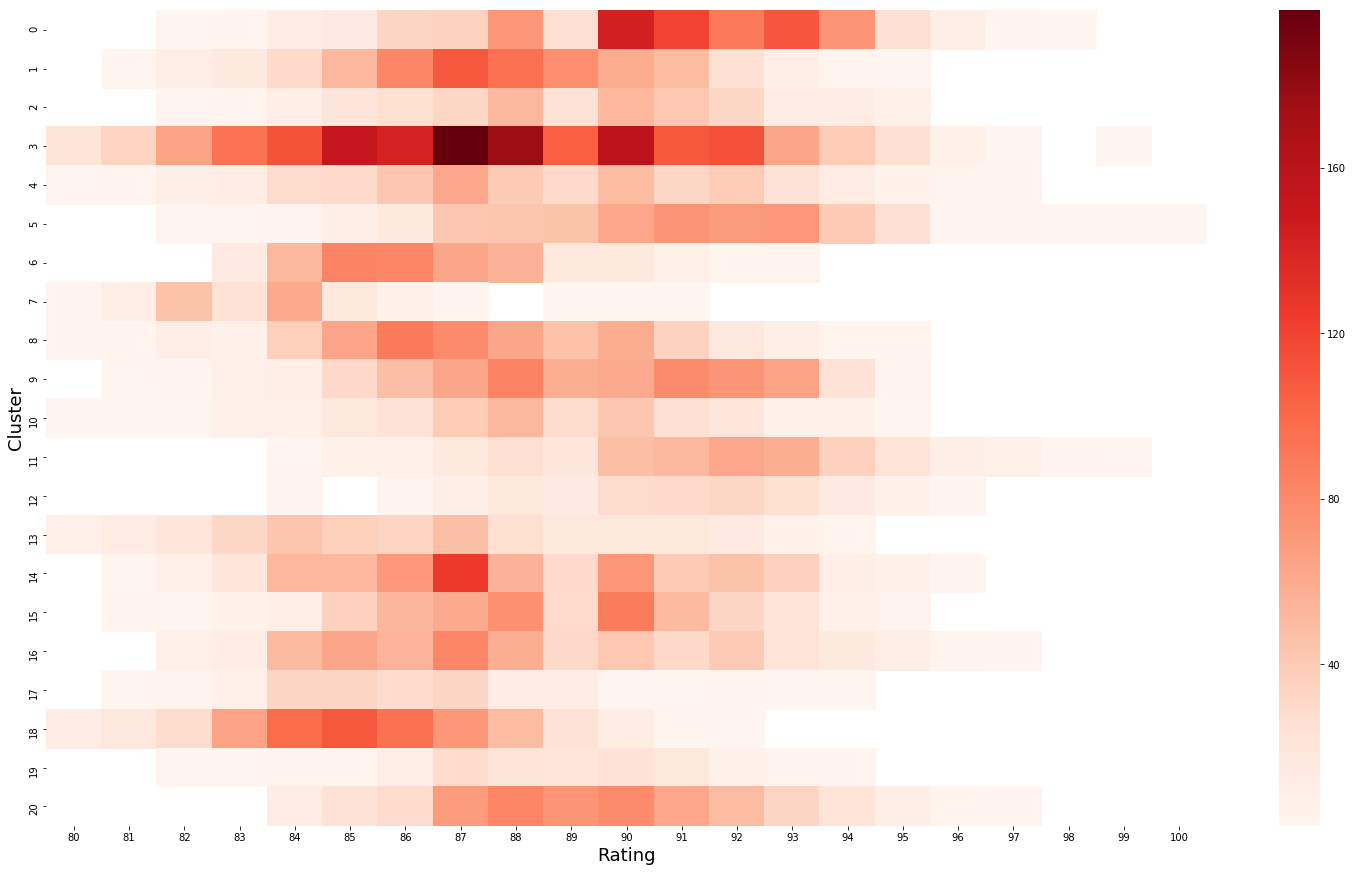

In [19]:
clusters = df.groupby(['cluster', 'rating']).size()
fig, ax1 = plt.subplots(figsize = (26, 15))
sns.heatmap(clusters.unstack(level = 'rating'), ax = ax1, cmap = 'Reds')

ax1.set_xlabel('Rating').set_size(18)
ax1.set_ylabel('Cluster').set_size(18)


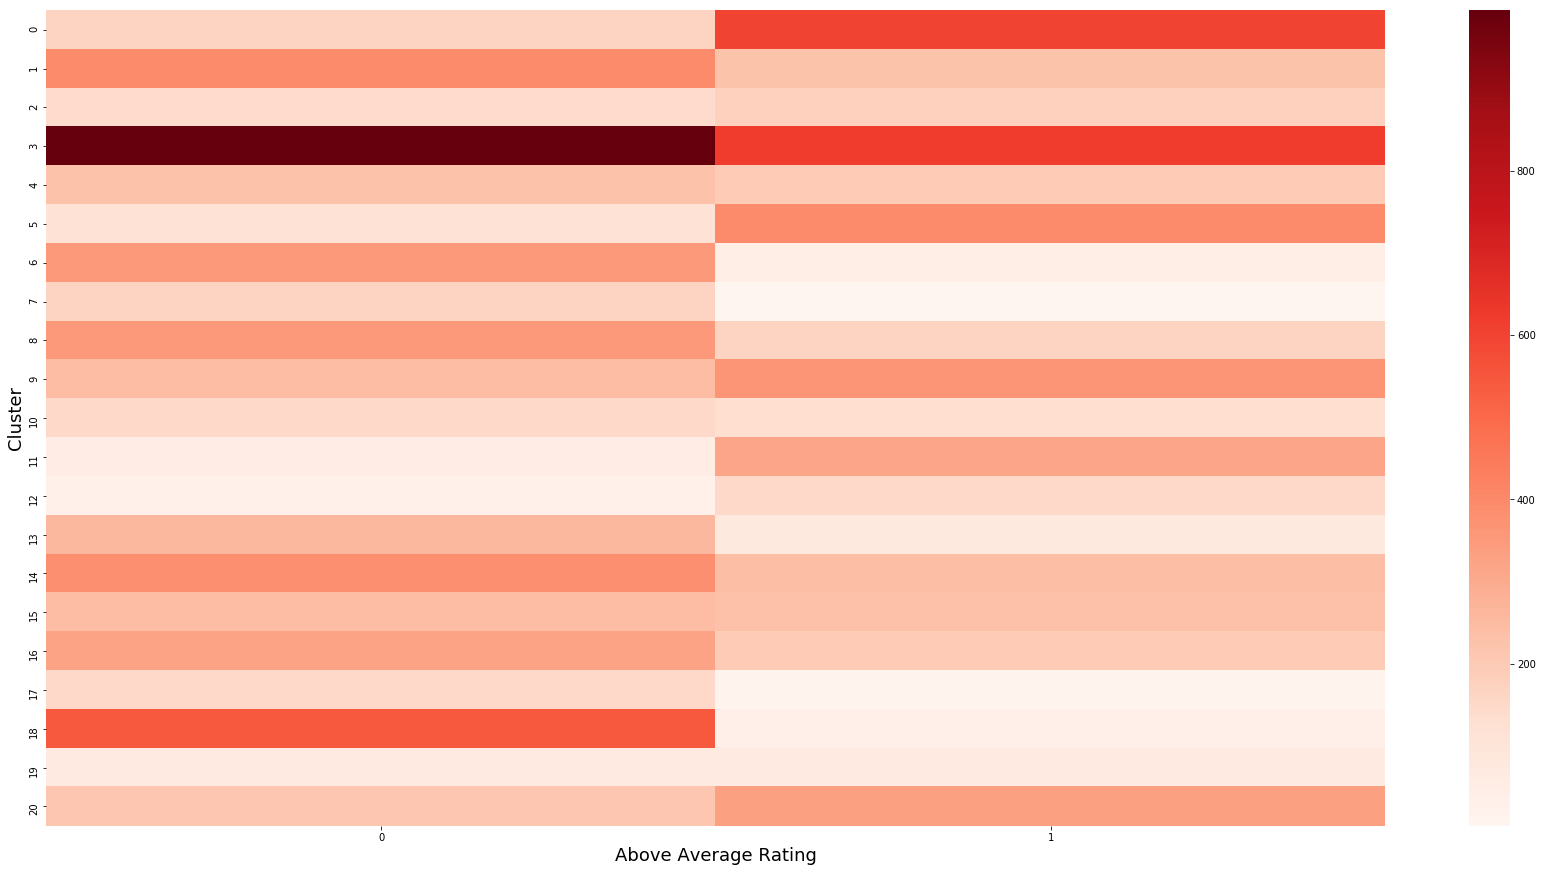

In [20]:
clusters = df.groupby(['cluster', 'above_avg']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'above_avg'), ax = ax2, cmap="Reds")

ax2.set_xlabel('Above Average Rating').set_size(18)
ax2.set_ylabel('Cluster').set_size(18)

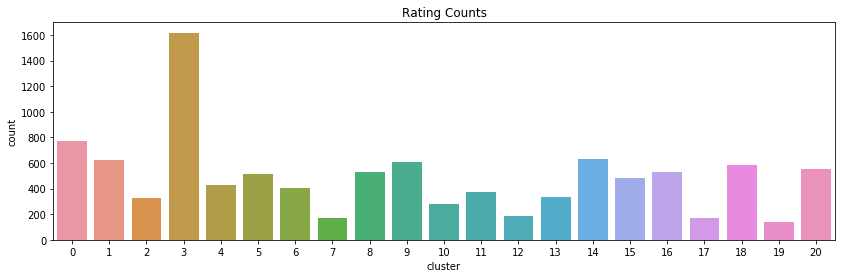

In [21]:
plt.figure(figsize=(14,4))
sns.countplot(x='cluster', data=df).set_title("Rating Counts")
plt.show()


In [22]:
above_avg = df.loc[df['above_avg'] == 1]
above_avg.describe()

,rating,price,word_count,above_avg,cluster
count,4629.000000,4629.000000,4629.000000,4629.0,4629.000000
mean,91.295528,50.236120,44.047526,1.0,7.983150
std,1.763436,59.810878,9.983192,0.0,6.266322
min,89.000000,8.000000,14.000000,1.0,0.000000
25%,90.000000,29.000000,37.000000,1.0,3.000000
50%,91.000000,39.000000,43.000000,1.0,8.000000
75%,92.000000,55.000000,50.000000,1.0,13.000000
max,100.000000,2013.000000,92.000000,1.0,20.000000


In [23]:
not_above = df.loc[df['above_avg'] == 0]
not_above.describe()

,rating,price,word_count,above_avg,cluster
count,5605.000000,5605.000000,5605.000000,5605.0,5605.000000
mean,85.796253,21.884032,33.686173,0.0,9.218733
std,1.858259,11.764816,9.374124,0.0,6.256443
min,80.000000,4.000000,3.000000,0.0,0.000000
25%,85.000000,14.000000,27.000000,0.0,3.000000
50%,86.000000,19.000000,33.000000,0.0,8.000000
75%,87.000000,27.000000,40.000000,0.0,15.000000
max,88.000000,143.000000,89.000000,0.0,20.000000


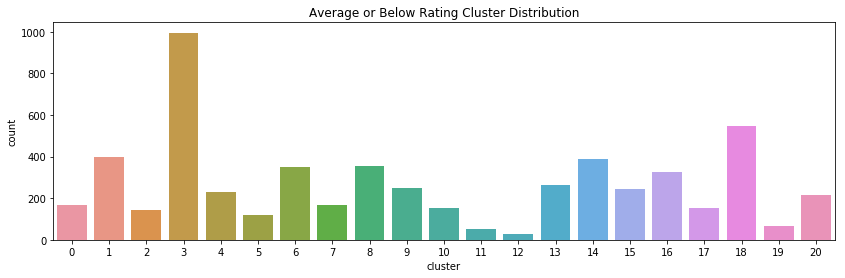

In [24]:
plt.figure(figsize=(14,4))
sns.countplot(x='cluster', data=not_above).set_title("Average or Below Rating Cluster Distribution")
plt.show()

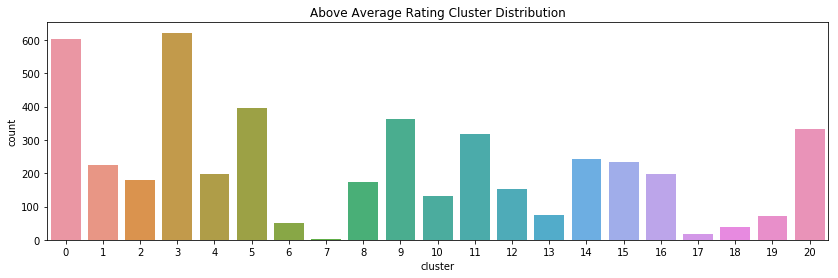

In [25]:
plt.figure(figsize=(14,4))
sns.countplot(x='cluster', data=above_avg).set_title("Above Average Rating Cluster Distribution")
plt.show()